In [93]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np


In [94]:
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [95]:
y = train_data.Survived

train_data.drop(['Survived', 'Name'], axis=1, inplace =True)
test_data.drop(['Name'], axis=1, inplace =True)
# We are dropping Name because there shoudn't be dependency beetween name and probability of surviving


In [96]:
print(train_data.head())

   PassengerId  Pclass     Sex   Age  SibSp  Parch            Ticket     Fare  \
0            1       3    male  22.0      1      0         A/5 21171   7.2500   
1            2       1  female  38.0      1      0          PC 17599  71.2833   
2            3       3  female  26.0      0      0  STON/O2. 3101282   7.9250   
3            4       1  female  35.0      1      0            113803  53.1000   
4            5       3    male  35.0      0      0            373450   8.0500   

  Cabin Embarked  
0   NaN        S  
1   C85        C  
2   NaN        S  
3  C123        S  
4   NaN        S  


In [97]:
train_data.replace('male',0, inplace=True)
train_data.replace('female',1, inplace=True)
test_data.replace('female',1, inplace=True)
test_data.replace('male',0, inplace=True)

In [98]:
print(train_data.head())

   PassengerId  Pclass  Sex   Age  SibSp  Parch            Ticket     Fare  \
0            1       3    0  22.0      1      0         A/5 21171   7.2500   
1            2       1    1  38.0      1      0          PC 17599  71.2833   
2            3       3    1  26.0      0      0  STON/O2. 3101282   7.9250   
3            4       1    1  35.0      1      0            113803  53.1000   
4            5       3    0  35.0      0      0            373450   8.0500   

  Cabin Embarked  
0   NaN        S  
1   C85        C  
2   NaN        S  
3  C123        S  
4   NaN        S  


In [99]:
median_age = train_data.median().Age
median_fare = train_data.median().Fare
print('Median age: ', median_age)
train_data.Age.fillna(median_age, inplace=True)
test_data.Age.fillna(median_age, inplace=True)
test_data.Fare.fillna(median_fare, inplace=True)

Median age:  28.0


In [100]:
na_no_cabin = sum(train_data.Cabin.isna())
print(na_no_cabin)

# 687 of 891 'Cabin' values is missing so I decided to drop this column
train_data.drop(['Cabin','Ticket'], axis=1, inplace =True)
test_data.drop(['Cabin','Ticket'], axis=1, inplace =True)

687


In [101]:
print(sum(train_data.Embarked.isna()))

# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(train_data, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

X_train = pd.get_dummies(X_train_full, dummy_na=True)
X_valid = pd.get_dummies(X_valid_full , dummy_na=True)
X_test = pd.get_dummies(test_data, dummy_na=True)


2


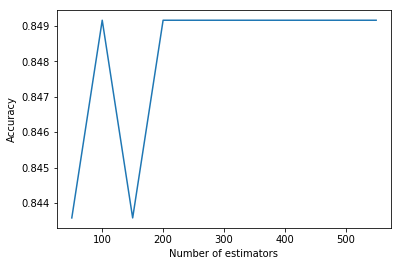

In [102]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Searching for best number of estimators in RandomForestClassifier

li = [ i*50 for i in range(12) if i>0]

results ={} 

for i in li:
    RFmodel = RandomForestClassifier(n_estimators=i, random_state=0)

    RFmodel.fit(X_train, y_train)

    RFscore = RFmodel.score( X_valid, y_valid)
    
    
    results[i] = RFscore
    
%matplotlib inline

plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.plot(results.keys(), results.values())
plt.show()

In [103]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# XGBoost model

boost_model = XGBClassifier(n_estimators = 1000, learning_rate =0.05, n_jobs=4)
boost_model.fit(X_train, y_train,
             early_stopping_rounds=3, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)


XGBpredictions = boost_model.predict(X_valid)

XGBscore = accuracy_score(y_valid,XGBpredictions)
print(XGBscore)

0.8268156424581006


In [104]:
from sklearn.linear_model import SGDClassifier

# Random Forest model

RFmodel = RandomForestClassifier(n_estimators=200, random_state=0)
RFmodel.fit(X_train, y_train)

# Normalization for Stochastic Gradient Descent classifier

scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_valid_norm = scaler.transform(X_valid)
X_test_norm = scaler.transform(X_test)
SGDmodel = SGDClassifier(loss="hinge")
SGDmodel.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
SGDscore = SGDmodel.score( X_valid_norm, y_valid)
RFscore = RFmodel.score( X_valid, y_valid)
print('SGD: ', SGDscore, '\n'
     'Random Forest: ', RFscore)

SGD:  0.8044692737430168 
Random Forest:  0.8491620111731844


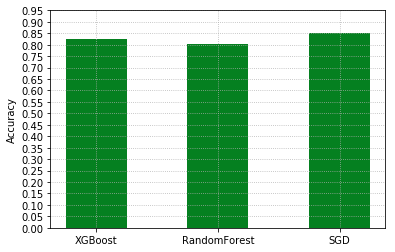

In [106]:
# Comparison of diffrent models based on accuracy
N = 3
ind = np.arange(N)

# XGBoost, RandomForest, SGD
scores = (XGBscore, SGDscore, RFscore)

comp = plt.bar(ind , scores, 0.5, color = '#058020')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(ls=':')
plt.xticks(ind, ('XGBoost', 'RandomForest', 'SGD'))
plt.show()

In [107]:
ifna = X_test.isna()
print(ifna.any())

X_test.fill


PassengerId     False
Pclass          False
Sex             False
Age             False
SibSp           False
Parch           False
Fare            False
Embarked_C      False
Embarked_Q      False
Embarked_S      False
Embarked_nan    False
dtype: bool


AttributeError: 'DataFrame' object has no attribute 'fill'

In [108]:
# Predicting test data

def generate_test_predictions(model = 'SGD'):
    if model == 'SGD':
        test_pred = SGDmodel.predict(X_test_norm)
    elif model == 'XGB':
        test_pred = boost_model.predict(X_test)
    elif model == 'RF':
        test_pred = RFmodel.predict(X_test)



    output = pd.DataFrame({'PassengerId': X_test.PassengerId,
                           'Survived': test_pred})
    output.to_csv('prices_{}.csv'.format(model), index=False)
    




In [109]:
generate_test_predictions('RF')

